In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
!pip install squarify
import squarify

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
!pip install --upgrade xlrd
!pip install openpyxl
import re

# For Show All Columns/Rows
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pakistans-national-assembly-attendance-20182022/Attendence of Members - Sessions 21 - 43.xls
/kaggle/input/pakistans-national-assembly-attendance-20182022/Attendence of Members - Sessions 1 - 20.xls
/kaggle/input/pak-mans-external-data/Pak MNAs.xlsx
/kaggle/input/mna-names/names.csv
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 989.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 1.5 MB/s eta 0:00:00


# Load Data

In [2]:
path = '../input/pakistans-national-assembly-attendance-20182022/Attendence of Members - Sessions 21 - 43.xls'
df1=pd.read_excel(path, sheet_name='Session 1 to 20', header=None)
df2=pd.read_excel(path,sheet_name='Attendence of Members - Session', header=None)

## Append data sets

In [3]:
#Append tha data sets
df= df1.append(df2)
df.columns= ['1', '2','3','4']
df.reset_index(inplace=True,drop=True)
df.shape

(76241, 4)

# Cleaning Data

## Drop Unnecessary Rows

In [4]:
# Drop the first column
df.drop('1',axis=1,inplace=True)

In [5]:
df.columns= ['Constituency','Name_of_Member','Status']

In [6]:
df[df['Constituency'].isnull()].sample(10) 

,Constituency,Name_of_Member,Status
74955,NaN,NaN,NaN
11862,NaN,"5th Sitting held on Friday, the 18th January, ...",NaN
68568,NaN,NATIONAL ASSEMBLY SECRETARIAT,NaN
37047,NaN,(Notice Office),NaN
43082,NaN,NATIONAL ASSEMBLY SECRETARIAT,NaN
67773,NaN,NATIONAL ASSEMBLY SECRETARIAT,NaN
20951,NaN,NATIONAL ASSEMBLY SECRETARIAT,NaN
48435,NaN,"5th Sitting held on Monday, the 1st February, ...",NaN
64915,NaN,(Notice Office),NaN
55576,NaN,NATIONAL ASSEMBLY SECRETARIAT,NaN


**We can Drop All The Rows Contain Null Values**

In [7]:
#Drop unnecessary rows
df.drop(df.index[df['Status'].isnull()], inplace=True)
df.drop(df.index[df['Constituency'].isnull()], inplace=True)
df.drop(df.index[df['Constituency']=='Constituency'],inplace=True)
df.drop(df.index[df['Constituency']=='(Notice Office)'],inplace=True)
df.drop(df.index[df['Constituency']=='Consituancy'],inplace=True)

#### Show all the name with Constituency

In [8]:
'''for i in df['Constituency'].unique():
    print(i)
    print(df[df['Constituency']==i].value_counts())
    print("---------------------------------------")'''

'for i in df[\'Constituency\'].unique():\n    print(i)\n    print(df[df[\'Constituency\']==i].value_counts())\n    print("---------------------------------------")'

## Correct the Names

In [9]:
df['Constituency'].replace('Reserved Seats','Reserved Seat', inplace= True)
df['Constituency'].replace('Reserved Seate','Reserved Seat', inplace= True)
df['Constituency'].replace('Reserve Seat','Reserved Seat', inplace= True)
df['Constituency'].replace('Reserve seat','Reserved Seat', inplace= True)
df['Constituency'].replace('Reserved seat','Reserved Seat', inplace= True)

In [10]:
df_copy=df.copy()

 **Alot of name requires correction.**
**For this we use external data.**
**I use https://na.gov.pk/en/all_members.php**

In [11]:
url='../input/mna-names/names.csv'
names=pd.read_csv(url, header=None)

In [12]:
# Correct the names
for i in np.arange(len(names)):
    df_copy['Name_of_Member'].replace(names[0][i],names[1][i], inplace= True)

In [13]:
# See Again all the name with Constituency
'''for i in df_copy['Constituency'].unique():
    print(i)
    print(df_copy[df_copy['Constituency']==i].value_counts())
    print("---------------------------------------")'''

'for i in df_copy[\'Constituency\'].unique():\n    print(i)\n    print(df_copy[df_copy[\'Constituency\']==i].value_counts())\n    print("---------------------------------------")'

In [14]:
# Saperate The Elected and Reserved Seats By Creating New Column "Type"
def type(x):
    if x == 'Reserved Seat':
        return 'Reserved'
    else:
        return 'Elected'

df_copy['Type'] = df_copy['Constituency'].apply(lambda x: type(x))
df_copy['Type'].shape

(74222,)

# Visualization

### Pie Chart

In [15]:
Reserved = df_copy['Type'][df_copy['Type']=="Reserved"].value_counts()/74222*100
Elected = df_copy['Type'][df_copy['Type']=="Elected"].value_counts()/74222*100
percentage = [Reserved,Elected]

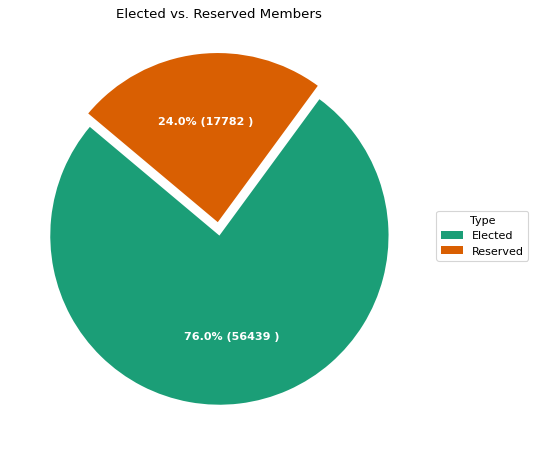

In [16]:
df_pie = df_copy.groupby('Type').size().reset_index(name='counts')
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(aspect="equal"), dpi= 80)
data = df_pie['counts']
categories = df_pie['Type']
explode = [0,0.08]
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d} )".format(pct, absolute)
wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors=plt.cm.Dark2.colors,
                                 startangle=140,
                                 explode=explode)
# Decoration
ax.legend(wedges, categories, title="Type", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=10, weight=700)
ax.set_title("Elected vs. Reserved Members")
plt.show()

**It Shows That Two Third of The Total Seats Are Elected**

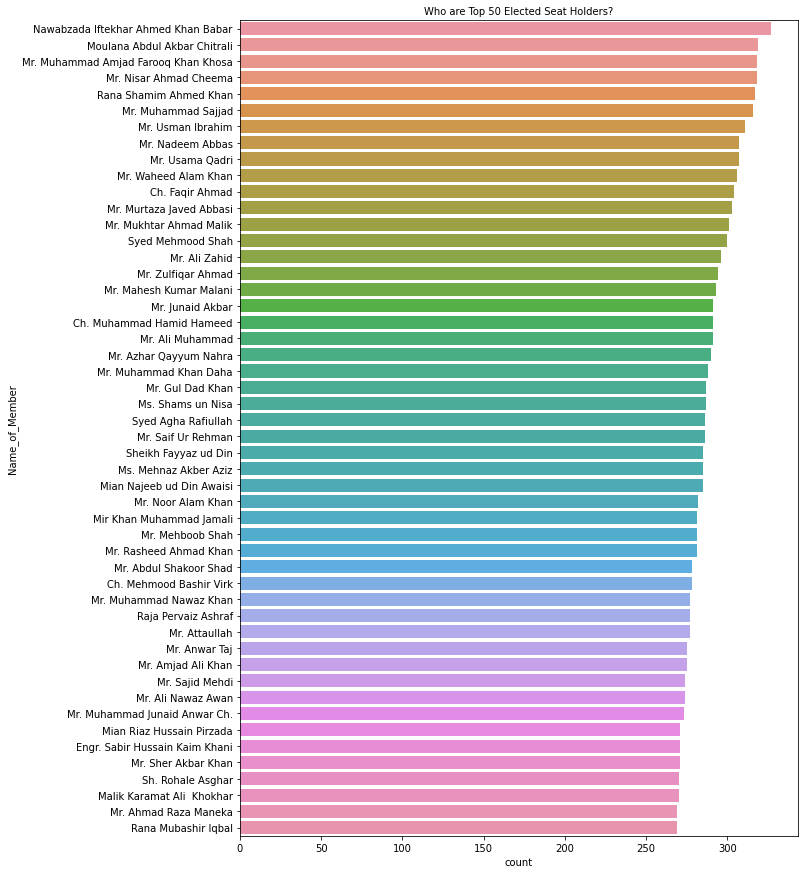

In [17]:
# Who are Top 50 Elected Seat Holders?
plt.figure(figsize = (10,15))
elected = df_copy[df_copy['Type']=='Elected']
order = elected['Name_of_Member'].value_counts().index[:50]
ax = sns.countplot(y='Name_of_Member', data=elected, order = order)
ax.set_title('Who are Top 50 Elected Seat Holders?', fontsize=10)
plt.show()

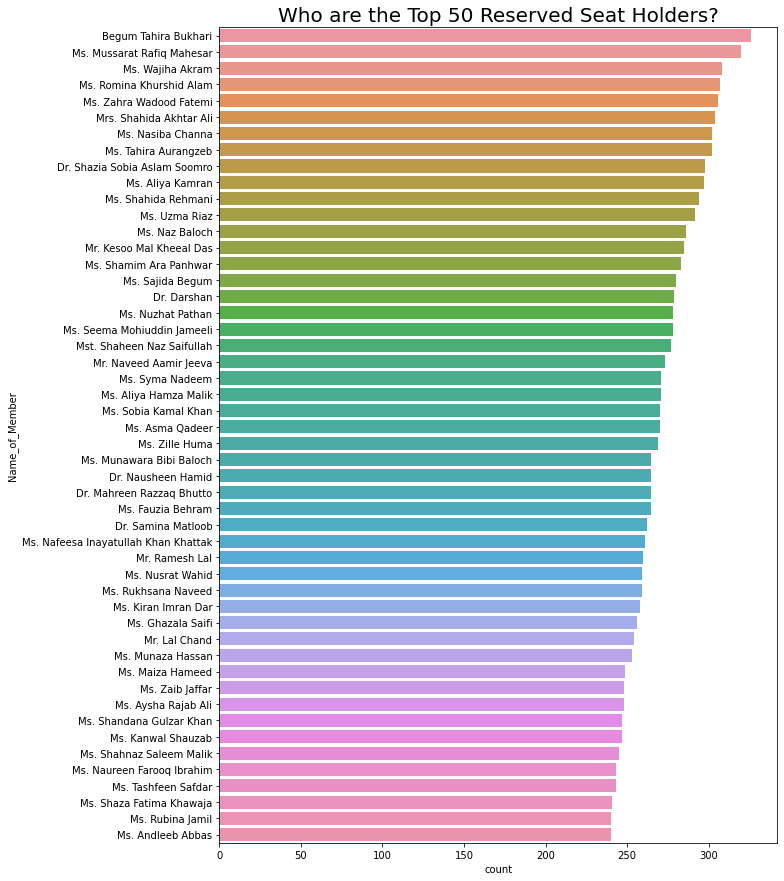

In [18]:
# Who are the Top 50 Reserved Seat Holders?
plt.figure(figsize = (10,15))
reserved = df_copy[df_copy['Type']=='Reserved']
ax = sns.countplot(y='Name_of_Member', data=reserved, order = reserved['Name_of_Member'].value_counts().index[:50])
ax.set_title('Who are the Top 50 Reserved Seat Holders?', fontsize=20)
plt.show()

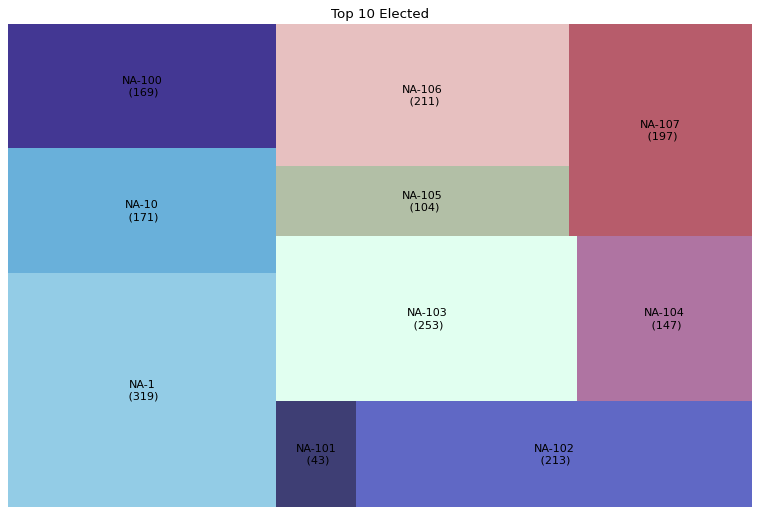

In [19]:
# Square Chart
df_squr = elected.groupby('Constituency').size().reset_index(name='counts')
labels = df_squr.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
sizes = df_squr['counts'].values.tolist()[:10]
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]
colors = ['#78C0E0', '#449DD1', '#150578', '#0E0E52', '#3943B7', '#DAFFED', '#9C528B', '#9FAF90',
         '#E2B1B1', '#A63446']
plt.figure(figsize=(12,8), dpi= 80)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

plt.title('Top 10 Elected')
plt.axis('off')
plt.show()

In [20]:
# Use https://na.gov.pk/en/all_members.php
url1='../input/pak-mans-external-data/Pak MNAs.xlsx'
party=pd.read_excel(url1, header=0)
party.drop(columns=['Constituency/Halqa', 'Address (Permanent/Local)', 'Phone','Picture' ], inplace=True)
party.sample(6)

,Constituency,Name,Party
305,RESERVED,Ms. Fauzia Behram,PTI
44,NA-46,Mr. Sajid Hussain Turi,PPPP
133,NA-135,Malik Karamat Ali Khokhar,PTI
70,NA-72,Chaudhry Armaghan Subhani,PML-N
90,NA-92,Syed Javed Hasnain,PML-N
62,NA-64,Sardar Zulfiqar Ali Khan Dullah,PTI


In [21]:
# Prepare Data For Visualization
elected = df_copy[df_copy['Type']=='Elected']
df_elected = pd.merge(elected, party, on = "Constituency" , how='inner')
df_elected.drop(columns=['Name' ], inplace=True)
df_elected.sample(3)

,Constituency,Name_of_Member,Status,Type,Party
8502,NA-40,Mr. Gul Dad Khan,P,Elected,PTI
21728,NA-116,Sahibzada Muhammad Ameer Sultan,P,Elected,PTI
49283,NA-267,Syed Mehmood Shah,P,Elected,MMAP


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator


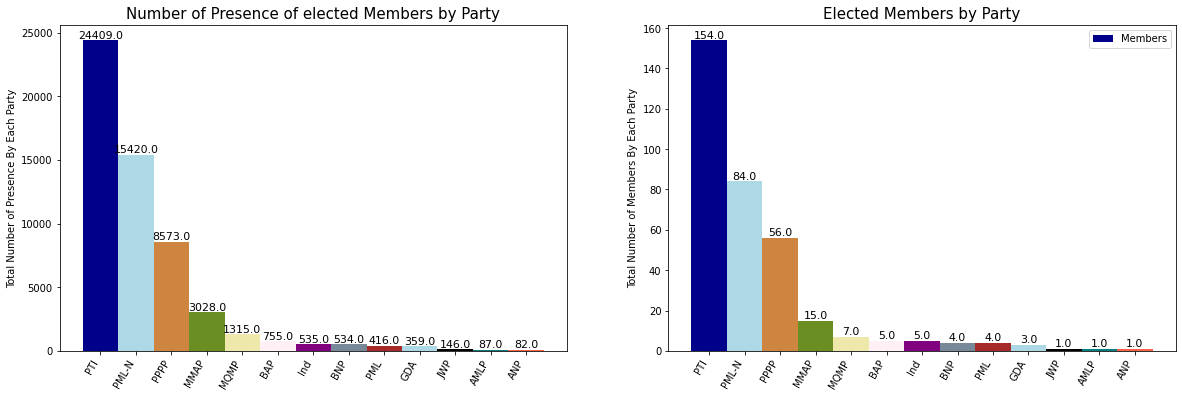

In [22]:
# Bar Chart For Elected
import random
import math
df_party_elec= df_elected[['Party','Status']].groupby(['Party'])['Status'] \
                             .count() \
                             .reset_index(name='counts') \
                             .sort_values(['counts'], ascending=False)
df_party_members= party[['Party','Name']].groupby(['Party'])['Name'] \
                             .count() \
                             .reset_index(name='counts_nam') \
                             .sort_values(['counts_nam'], ascending=False)
n = math.ceil(df_party_elec['Party'].unique().__len__()+0.1)
all_colors = list(plt.cm.colors.cnames.keys())
random.seed(100)
c = random.choices(all_colors, k=n)

plt.figure(figsize=(20,6))
plt.subplot(121)
plt.bar(df_party_elec['Party'], df_party_elec['counts'], color=c, width=1, label='Presence')
for i, val in enumerate(df_party_elec['counts'].values):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':11})
plt.title("Number of Presence of elected Members by Party", fontsize=15)
plt.ylabel('Total Number of Presence By Each Party')
plt.gca().set_xticklabels(df_party_elec['Party'], rotation=60, horizontalalignment= 'right')


plt.subplot(122)
plt.bar(df_party_members['Party'], df_party_members['counts_nam'], color=c, width=1, label='Members')
for i, val in enumerate(df_party_members['counts_nam'].values):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':11})


plt.gca().set_xticklabels(df_party_elec['Party'], rotation=60, horizontalalignment= 'right')
plt.title("Elected Members by Party", fontsize=15)
plt.ylabel('Total Number of Members By Each Party')
plt.legend()
plt.show();

In [23]:
# Bar Chart For Reserved Seats
reserved = df_copy[df_copy['Type']=='Reserved']
df_reserved = pd.merge(reserved, party,left_on='Name_of_Member', right_on='Name', how="inner")
df_reserved.drop(columns=['Constituency_x', 'Constituency_y', 'Name'], inplace=True)
df_reserved.sample(3)

,Name_of_Member,Status,Type,Party
4095,Ms. Kanwal Shauzab,P,Reserved,PTI
11989,Mr. Kesoo Mal Kheeal Das,P,Reserved,PML-N
13299,Ms. Shunila Ruth,P,Reserved,PTI


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator


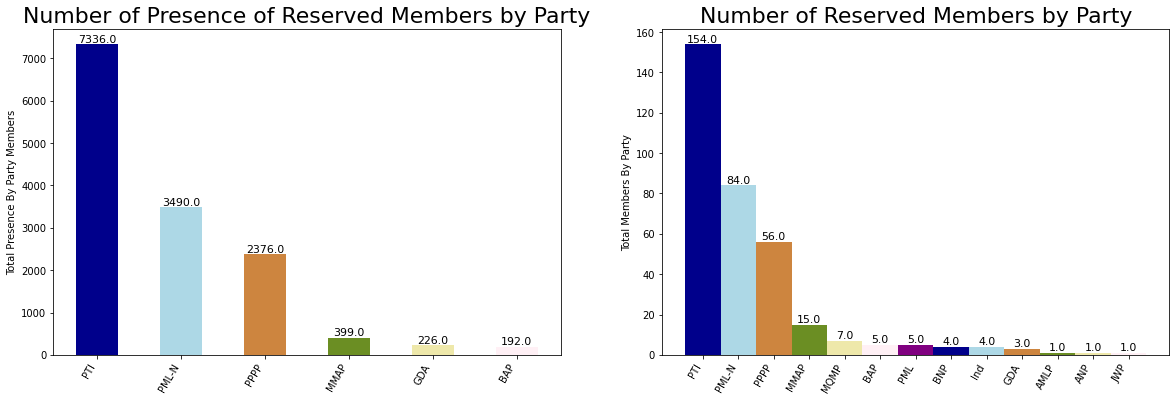

In [24]:
import random
import math
df_party_rese= df_reserved[['Party','Status']].groupby(['Party'])['Status'] \
                             .count() \
                             .reset_index(name='counts') \
                             .sort_values(['counts'], ascending=False)
df_party_members= party[['Party','Name']].groupby(['Party'])['Name'] \
                             .count() \
                             .reset_index(name='counts_nam') \
                             .sort_values(['counts_nam'], ascending=False)
n = math.ceil(df_party_rese['Party'].unique().__len__()+0.1)
all_colors = list(plt.cm.colors.cnames.keys())
random.seed(100)
c = random.choices(all_colors, k=n)
plt.figure(figsize=(20,6))

plt.subplot(121)
plt.bar(df_party_rese['Party'], df_party_rese['counts'], color=c, width=.5)
for i, val in enumerate(df_party_rese['counts'].values):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':11})
plt.gca().set_xticklabels(df_party_rese['Party'], rotation=60, horizontalalignment= 'right')
plt.title("Number of Presence of Reserved Members by Party", fontsize=22)
plt.ylabel('Total Presence By Party Members')

plt.subplot(122)
plt.bar(df_party_members['Party'], df_party_members['counts_nam'], color=c, width=1, label='Members')
for i, val in enumerate(df_party_members['counts_nam'].values):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':11})

plt.gca().set_xticklabels(df_party_members['Party'], rotation=60, horizontalalignment= 'right')
plt.title("Number of Reserved Members by Party", fontsize=22)
plt.ylabel('Total Members By Party')
plt.show()

# Pakistan Zinda Abad